In [1]:
data_explanation = {"CHANNEL": "Channel used to send the packet",
"CODR" : "Coding rate packet",
"CREATED AT": "Timestamp indicating the time when the entry has been created inside the database",
"DATR" :"SF and bandwidth of the packet",
"DEV_ADDR" :"Unique identifier of the device inside the network",
"DEV_EUI" : "Unique identifier of the physical device (None if the device is unknown)",
"FREQUENCY" : "Frequency of the sent packet in MHz",
"GATEWAY" : "GW MAC ADDRESS which received the packet",
"LSNR" : "Received signal to noise ratio of the packet",
"FCNT" : "Frame counter: counter increasing for each packet sent from ED;used evaluate error rate",
"RSSI" : "Received packet signal strength",
"SIZE" : "Packet size (bytes)",
"CRC_STATUS" : "result: if 1 = passed if −1 = failed",
"TMST" : "Internal clock timestamp from gateway: used for synchronizing the downlink\
        with the end transmission of the uplink to communicate response to end-device",
"UID" : "Unique identifier of the entry inside the database}"}

In [88]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy import optimize
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import normalize

In [3]:
data = pd.read_csv("anonymized_spazio_radio_v2.csv")

In [4]:
def countna():
    nasdict = {}
    for i in data.columns:
        nasdict[i] = [('not na', data[i].notna().sum()),('na', data[i].isna().sum())]
    return nasdict

In [5]:
countna()

{'ant': [('not na', 186632), ('na', 0)],
 'chan': [('not na', 186632), ('na', 0)],
 'codr': [('not na', 186632), ('na', 0)],
 'created_at': [('not na', 186632), ('na', 0)],
 'datr': [('not na', 186632), ('na', 0)],
 'dev_addr': [('not na', 186632), ('na', 0)],
 'dev_eui': [('not na', 186632), ('na', 0)],
 'dev_nonce': [('not na', 5106), ('na', 181526)],
 'freq': [('not na', 186632), ('na', 0)],
 'gateway': [('not na', 186632), ('na', 0)],
 'lsnr': [('not na', 186632), ('na', 0)],
 'ns_time': [('not na', 186632), ('na', 0)],
 'rssi': [('not na', 181526), ('na', 5106)],
 'rssic': [('not na', 186632), ('na', 0)],
 'rssis': [('not na', 176025), ('na', 10607)],
 'rssisd': [('not na', 176025), ('na', 10607)],
 'size': [('not na', 186632), ('na', 0)],
 'time': [('not na', 186622), ('na', 10)],
 'tmms': [('not na', 186622), ('na', 10)],
 'tmst': [('not na', 186632), ('na', 0)],
 'FCnt': [('not na', 181526), ('na', 5106)],
 'valueRaw': [('not na', 186632), ('na', 0)],
 'value_minutes': [('not n

### It is noticable that the number of rows where rssi and rssic are different is the same number of rows of rssi Na

In [6]:
data.codr.unique() #codr has only one value across the data

array(['4/5'], dtype=object)

In [7]:
((data.loc[data['rssi'].notna(),['rssi']]).values ==\
 (data.loc[data['rssi'].notna(),['rssic']]).values).all()
#validating that rssi and rssic have equal values but rssic has no Na's so we drop rssi

True

In [8]:
len(data.dev_eui.unique()) == len(data.dev_addr.unique())

True

In [9]:
data = data.drop(columns = ['dev_nonce']) # has 181526 NA
data = data.drop(columns = ['codr']) #has only one value 
data = data.drop(columns = ['dev_eui']) #mapping one to one with dev_addr
data = data.drop(columns = ['ns_time']) #we drop ns_time because
        #the time of inserting the data inside the database is not relavant to our analysis
data = data.drop(columns = ['rssi']) #duplicated data from rssic
data = data.drop(columns = ['created_at','tmms','value_minutes','tmst',]) 
#duplicated and irrelevant timestamps

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186632 entries, 0 to 186631
Data columns (total 14 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ant       186632 non-null  int64  
 1   chan      186632 non-null  int64  
 2   datr      186632 non-null  object 
 3   dev_addr  186632 non-null  object 
 4   freq      186632 non-null  float64
 5   gateway   186632 non-null  object 
 6   lsnr      186632 non-null  float64
 7   rssic     186632 non-null  int64  
 8   rssis     176025 non-null  float64
 9   rssisd    176025 non-null  float64
 10  size      186632 non-null  int64  
 11  time      186622 non-null  object 
 12  FCnt      181526 non-null  float64
 13  valueRaw  186632 non-null  int64  
dtypes: float64(5), int64(5), object(4)
memory usage: 19.9+ MB


In [11]:
data['time'] = pd.to_datetime(data['time'])
data['time'] = data['time'].dt.tz_convert(None)

In [12]:
data.time = data.time.values.astype(np.int64) // 10 ** 9   #convert time to unix timestamp

In [13]:
data = data.dropna()

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171208 entries, 0 to 186631
Data columns (total 14 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ant       171208 non-null  int64  
 1   chan      171208 non-null  int64  
 2   datr      171208 non-null  object 
 3   dev_addr  171208 non-null  object 
 4   freq      171208 non-null  float64
 5   gateway   171208 non-null  object 
 6   lsnr      171208 non-null  float64
 7   rssic     171208 non-null  int64  
 8   rssis     171208 non-null  float64
 9   rssisd    171208 non-null  float64
 10  size      171208 non-null  int64  
 11  time      171208 non-null  int64  
 12  FCnt      171208 non-null  float64
 13  valueRaw  171208 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 19.6+ MB


In [38]:
data['size'].unique()

array([64], dtype=int64)

In [39]:
#after dropping Na, Size has only 64
data = data.drop(columns=['size'])

In [40]:
categorical = ['datr','dev_addr','gateway','chan','ant','freq']
numeric= ['lsnr','rssic','rssis','rssisd']

In [65]:
datadum = pd.get_dummies(data, columns = categorical)

In [66]:
datadum[numeric] = normalize(datadum[numeric])

In [67]:
X = datadum.drop(columns=['time','valueRaw']).values

In [68]:
wcss=[]
dbs=[]
for i in range(2,11): 
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,\
                    n_init=10,random_state=0,n_jobs=6 ).fit(X)
#inertia_ : Sum of squared distances of samples to their closest cluster center.
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_
    dbs.append(davies_bouldin_score(X, labels))
    print('clustering with k = {} done!'.format(i))

clustering with k = 2 done!
clustering with k = 3 done!
clustering with k = 4 done!
clustering with k = 5 done!
clustering with k = 6 done!
clustering with k = 7 done!
clustering with k = 8 done!
clustering with k = 9 done!
clustering with k = 10 done!


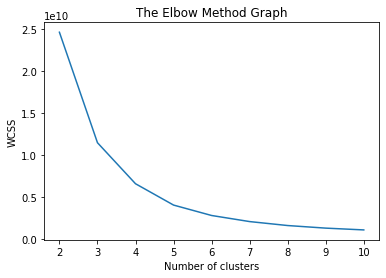

In [69]:
plt.plot(range(2,11),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

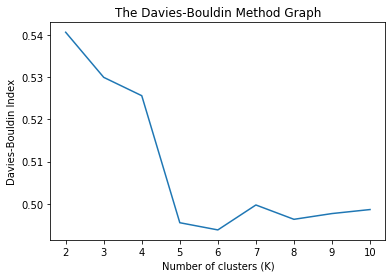

In [70]:
#Plot the Davies-Bouldin graph
plt.plot(range(2,11),dbs)
plt.title('The Davies-Bouldin Method Graph')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.show

# -------------------------------------------------------------------------------

### by comparing the DaviesBouldin and the Elbow method 7 is the best number of clusters

In [86]:
kmeans = KMeans(n_clusters=7, init ='k-means++', max_iter=300,\
                    n_init=10,random_state=0,n_jobs=6 ).fit(X)
labels = kmeans.labels_

In [109]:
data_labeled = data
data_labeled['label'] = labels

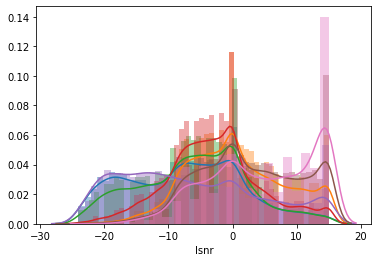

In [89]:
for i in np.unique(labels):
    sns.distplot(data[labels == i]['lsnr'])

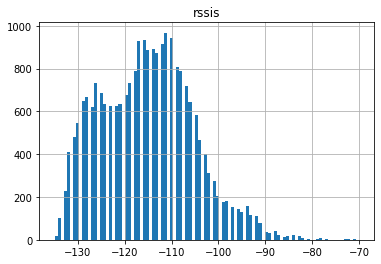

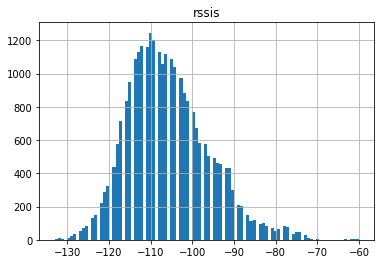

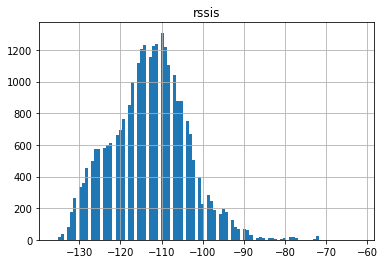

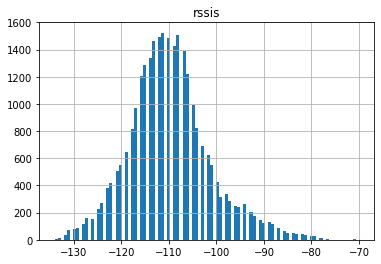

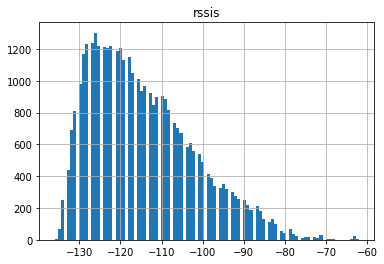

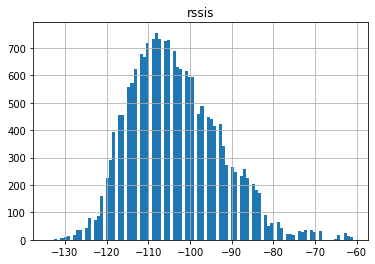

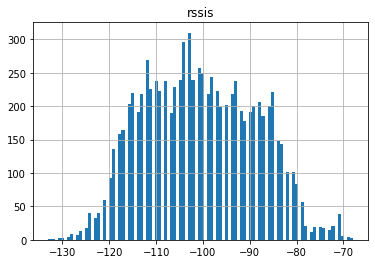

In [90]:
for i in np.unique(labels):
    data[labels == i].hist(bins = 100,column=['rssis'])

In [112]:
data_labeled.head()

,ant,chan,datr,dev_addr,freq,gateway,lsnr,rssic,rssis,rssisd,time,FCnt,valueRaw,label
0,1,23,SF12BW125,000000ff,868.5,7276FF002E061495,-18.0,-108,-126.0,0.0,1547648565,190.0,1547648566,4
1,0,6,SF12BW125,00000043,868.3,7276FF002E061495,12.0,-93,-93.0,0.0,1547649172,149.0,1547649173,4
2,1,23,SF12BW125,00000013,868.5,7276FF002E061495,14.0,-90,-90.0,0.0,1547650148,207.0,1547650149,4
3,1,21,SF12BW125,00000117,868.1,7276FF002E061495,-20.0,-108,-129.0,0.0,1547656287,99.0,1547656289,4
4,1,21,SF12BW125,00000055,868.1,7276FF002E061495,-6.0,-107,-115.0,0.0,1547656731,161.0,1547656732,4


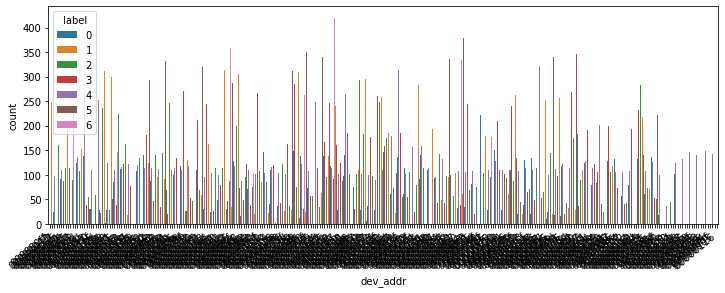

In [149]:
fig, ax = plt.subplots(figsize=(12,4))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
lsnr = sns.countplot(ax = ax,x="dev_addr", hue="label", data=data_labeled,)


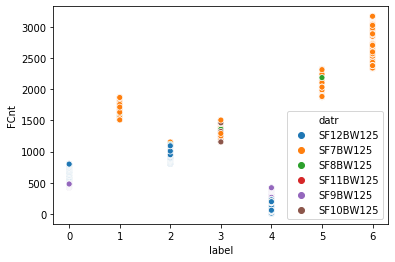

In [154]:
ax = sns.scatterplot(x="label", y="FCnt", hue='datr',data=data_labeled)